<a href="https://colab.research.google.com/github/GuillaumeMagnette/Stage_Tritons/blob/master/Image_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import urllib
#!pip install skimage
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#!git clone https://github.com/GuillaumeMagnette/Stage_Tritons.git


try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import save_img
mpl.rcParams['figure.figsize'] = (12, 5)

AUTOTUNE = tf.data.experimental.AUTOTUNE


import IPython.display as display
from PIL import Image
import os
import pathlib
import shutil
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

from google.colab import drive
!rm -rf /content/content
drive.mount('/content/drive')
#!cp '/content/drive/My Drive/slim.zip' slim.zip
!unzip -q /content/drive/"My Drive"/Stage/Stage_cropped.zip


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace database/Bascha_P01_T01_K03_F_Adult_4265_20190319190818.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
import numpy as np
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
from skimage import transform
from skimage.transform import rotate, AffineTransform, swirl
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  #parts = str(file_path).split("/")
  parts = tf.strings.split(file_path, os.path.sep)
  #print(type(parts[-1]))
  #print(parts[-1].numpy().decode("utf-8"))
  #test = str(parts)
  
  #data = pd.read_csv('/content/training.csv')
  #names = data[:,0]
  #id = patterns[patterns == lab]
  #for part in parts:
   # print(part)
  lab = parts[-2].numpy().decode("utf-8")  + '/'+ parts[-1].numpy().decode("utf-8")
  lab = parts[-1]
  #print(lab)
  #print(parts.  )

  #for l in np.range(lab):
    #print(l)

  i = 0
  while (parts[-1].numpy().decode("utf-8")[i] != "_"):
    i += 1
  
  #id = patterns[patterns == lab]
  #if (id.empty):
  #print(lab)

  
  # The second to last is the class-directory
  #print( tf.convert_to_tensor(lab[:i]))
  #print(CLASS_NAMES)
  #print(type(tf.convert_to_tensor(parts[-1].numpy().decode("utf-8")[:i])))
  #print(CLASS_NAMES[0])
  #print(type(CLASS_NAMES[0]))
  return tf.convert_to_tensor(parts[-1].numpy().decode("utf-8")[:i]) == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  height = input_shape[0]
  width = input_shape[1]

  if (img.shape[0] < img.shape[1]):
    img = tf.image.resize(img, [width, height])
    #print("height < width")
    img = tf.image.transpose(img)
  else:
    img = tf.image.resize(img, [height, width])
    #print("height > width")

  return img


def process_path(file_path):
  #print(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  #print(img)
  try:
    img = decode_img(img)
    #print("decoded")
    counter +=1
  except:
   # print("erreur décodage")
    pass

  return img, label

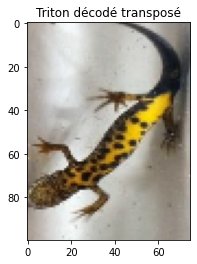

In [0]:
def prepare_img(input_shape,img_path):

  height = input_shape[0]
  width = input_shape[1]
  channel = input_shape[2]




  img = tf.io.read_file(img_path)

  try:
    img = decode_img(img)
  # print(img)
    #plt.title('Triton décodé')
  #plt.imshow(img)
  except:
    pass
  

  return img


input_shape = (100,75,3)
img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1024_20190605213228.jpg'
img = prepare_img(input_shape,img_path)
plt.title('Triton décodé transposé')
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 75, 3)


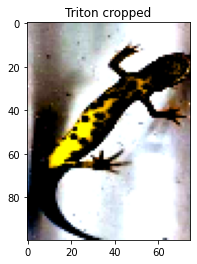

In [0]:
print(img.shape)
#image = tf.image.random_crop(img, size=[40, 40, 3])
image = tf.image.random_brightness(img, max_delta=0.15) # Random brightness
image = tf.image.random_flip_left_right(image)
image = tf.image.random_flip_up_down(image)
image = tf.image.random_contrast(image,0.5,3)
image = tf.image.random_saturation(image,0.5,3)
plt.title('Triton cropped')
plt.imshow(image)

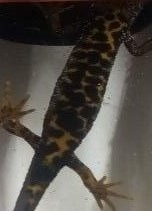

In [65]:
# load Image
img_path = '/content/database/Bascha_P01_T05_K20_U_Larva_8359_20190717223645.jpg'
#img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1039_20190607040030.jpg'
#img_path = '/content/database/Bascha_P01_T06_K13_M_Adult_1008_20190601154259.jpg'
img_path = '/content/database/Bascha_P01_T05_K18_M_Adult_6164_20190703234211.jpg'
img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1024_20190605213228.jpg'
img_path = '/content/database/Bascha_P01_T02_K13_M_Adult_750_20190531073133.jpg'

img = imread(img_path)
img = cv2.imread(img_path)
# plot original Image
#plt.imshow(img)
#plt.show()
cv2_imshow(img)

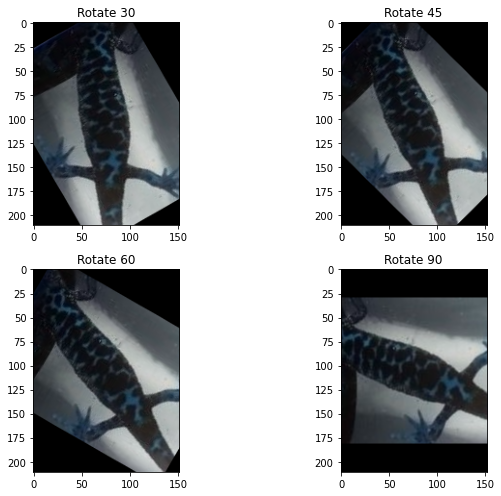

In [42]:
# image rotation using skimage.transformation.rotate
rotate30 = rotate(img, angle=30)
rotate45 = rotate(img, angle=45)
rotate60 = rotate(img, angle=60)
rotate90 = rotate(img, angle=90)
fig = plt.figure(tight_layout='auto', figsize=(10, 7))
fig.add_subplot(221)
plt.title('Rotate 30')
plt.imshow(rotate30)
fig.add_subplot(222)
plt.title('Rotate 45')
plt.imshow(rotate45)
fig.add_subplot(223)
plt.title('Rotate 60')
plt.imshow(rotate60)
fig.add_subplot(224)
plt.title('Rotate 90')
plt.imshow(rotate90)
plt.show()

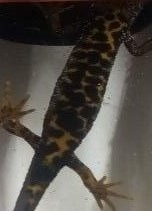

0.20136631197818017
0.17810418601969613
(251, 192, 3)
shape of cnt: (203, 1, 2)
rect: ((91.5, 107.0), (149.0, 186.0), -0.0)
Augmentation par couleurs


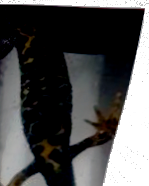

In [157]:
from random import random, uniform

# load Image
img_path = '/content/database/Bascha_P01_T05_K20_U_Larva_8359_20190717223645.jpg'
#img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1039_20190607040030.jpg'
#img_path = '/content/database/Bascha_P01_T06_K13_M_Adult_1008_20190601154259.jpg'
img_path = '/content/database/Bascha_P01_T05_K18_M_Adult_6164_20190703234211.jpg'
img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1024_20190605213228.jpg'
img_path = '/content/database/Bascha_P01_T02_K13_M_Adult_750_20190531073133.jpg'

def preprocess_newts(img_path):
  img = imread(img_path)
  img = cv2.imread(img_path)
# plot original Image
#plt.imshow(img)
#plt.show()
#cv2_imshow(img)


  h,w=img.shape[0:2]

### Add borders around the image to have more room for wraping and swirling
  shift = 20
  base_size=h+2*shift,w+2*shift,3
# make a 3 channel image for base which is slightly larger than target img
  base=np.zeros(base_size)
  cv2.rectangle(base,(0,0),(w+2*shift,h+2*shift),(255,255,255),40) # really thick white rectangle
  base[shift:h+shift,shift:w+shift]=img # this works
  img = base
#print(img)
#cv2_imshow(img)

  h,w=img.shape[0:2]

  print("Augmentation par déformation")

### image shearing using sklearn.transform.AffineTransform
# try out with differnt values of shear 

  shear = uniform(-.3, .3)
  print(shear)
  tfr = AffineTransform(shear=shear)
  sheared = transform.warp(img, tfr, order=1, preserve_range=True,mode='constant', cval=255)
#sheared_fig = plot_side_by_side(img, sheared, 'Original', 'Sheared')
#plt.title('shear')
#plt.imshow(sheared)
#v2_imshow(sheared)

### image swirling using sklearn swirl
# keep strength  between -1 and 1
# maximum radius = 500
# mode = constant because in case of "wrap" some parts of the newts go the other sides of the image. Bad for the training of the neural network
  strength = uniform(-1, 1)
#print(strength)
  swirled = swirl(sheared, rotation=0, strength=strength, radius=500,mode='constant', cval=255)
#plt.imshow(swirled)
#cv2_imshow(swirled)

  img = swirled
  #print(img.shape)
  img = img.astype(np.uint8)

  img0 = cv2.equalizeHist(img[:,:,0])
  img1 = cv2.equalizeHist(img[:,:,1])
  img2 = cv2.equalizeHist(img[:,:,2])
  img[:,:,0] = img0
  img[:,:,1] = img1
  img[:,:,2] = img2


#cv2_imshow(img)

  h,w=img.shape[0:2]



  hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS) 
  lower_yellow = np.array([5,15,25]) 
  upper_yellow = np.array([100,240,255]) 

  lower_yellow2 = np.array([160,15,25]) 
  upper_yellow2 = np.array([180,240,255]) 
#hsl(63, 20%, 81%)
  lower_black = np.array([0,0,50]) 
  upper_black = np.array([35,75,255]) 

  lower_black2 = np.array([155,0,50]) 
  upper_black2 = np.array([180,75,255]) 
# Here we are defining range of yellow color in HSL 
# This creates a mask of yellow coloured  
# objects found in the frame. 
  mask = cv2.inRange(hls, lower_yellow, upper_yellow)
  mask2 = cv2.inRange(hls, lower_yellow2, upper_yellow2)
  mask_b = cv2.inRange(hls, lower_black, upper_black) 
  mask_b2 = cv2.inRange(hls, lower_black2, upper_black2)

  mask = mask_b2+mask_b+mask+mask2
# The bitwise and of the frame and mask is done so  
# that only the blue coloured objects are highlighted  
# and stored in res 
#res = cv2.bitwise_or()
  res = cv2.bitwise_and(img,img, mask= mask) 
#cv2_imshow(img) 
#cv2_imshow(mask)
#cv2_imshow(res) 


  mask_blur = cv2.GaussianBlur(mask,(5,5),cv2.BORDER_DEFAULT)

  threshMap = cv2.threshold(mask_blur.astype("uint8"), 0, 255,
	  cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

  kernel = np.ones((7,7),np.uint8)
  threshMap = cv2.dilate(threshMap, kernel)
  threshMap = cv2.erode(threshMap, kernel)


#cv2_imshow(mask_blur)
#cv2_imshow(threshMap)

  canny_output = auto_canny(threshMap, sigma = 0.3)
#canny_output = cv2.convertScaleAbs(canny_output)
  kernel = np.ones((9,9),np.uint8)
  threshed = cv2.dilate(canny_output,kernel)


#print(canny_output[1])
#plt.imshow(canny_output)
#plt.colorbar()
#plt.show()


## findContours(查找轮廓)
  cnts = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]

#print(cnts[0])
#plt.imshow(threshed)
#plt.colorbar()
#plt.show()
#print(cnts.shape)

#new,contours, hierarchy = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#contours= sorted(contours, key = cv2.contourArea, reverse = True)[:4]
#c=contours[0]
#print(cv2.contourArea(c))
#final = cv2.drawContours(img, [c], -1, (255,0, 0), 3)


#cnts = canny_output
#cnts = sorted(canny_output, key=cv2.contourArea)
## sorted by area(按照面积排序)
  cnts = sorted(cnts, key=cv2.contourArea)

## get the maximum's boundinRect(获取最大边缘的外接矩形)
  cnt = cnts[-1]

## create mask(创建掩模)
  mask = np.ones_like(threshMap, np.uint8)*cv2.GC_PR_BGD
  cv2.drawContours(mask, cnt, -1, cv2.GC_FGD, -1)

#print("shape of cnt: {}".format(cnt.shape))

#plt.imshow(mask)
#plt.colorbar()
#plt.show()

#new_image = cv2.bitwise_and(img,img,mask=mask)
#print(mask)
  new_image = threshMap.copy()
  new_image[mask == 2] = 0  # Set values not masked to be 0

#plt.imshow(new_image)
#plt.colorbar()
#plt.show()

#retval = cv2.contourArea(cnt)
#print(retval)

  rect = cv2.minAreaRect(cnt)
  print("rect: {}".format(rect))

  box = cv2.boxPoints(rect)
  box = np.int0(box)

  width = int(rect[1][0])
  height = int(rect[1][1])

  src_pts = box.astype("float32")
  dst_pts = np.array([[0, height-1],
                    [0, 0],
                    [width-1, 0],
                    [width-1, height-1]], dtype="float32")
  M = cv2.getPerspectiveTransform(src_pts, dst_pts)
  warped = cv2.warpPerspective(img, M, (width, height))

#cv2_imshow(warped)

  print("Augmentation par couleurs")
  image = tf.image.random_brightness(warped, max_delta=0.15) # Random brightness
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_contrast(image,0.5,2)
  image = tf.image.random_saturation(image,0.5,2)

  if (image.shape[0] < image.shape[1]):
    image = tf.image.resize(image, [width, height])
    #print("height < width")
    image = tf.image.transpose(image)
  else:
    image = tf.image.resize(image, [height, width])
    #print("height > width")

  return image

#from keras.preprocessing.image import array_to_img, img_to_array
#img = img_to_array(image)
#cv2_imshow(img.astype('uint8'))



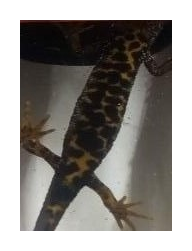

In [43]:
h,w=img.shape[0:2]

shift = 20
base_size=h+2*shift,w+2*shift,3
# make a 3 channel image for base which is slightly larger than target img
base=np.zeros(base_size)
cv2.rectangle(base,(0,0),(w+2*shift,h+2*shift),(255,255,255),40) # really thick white rectangle
base[shift:h+shift,shift:w+shift]=img # this works
img = base
#print(img)
cv2_imshow(img)

h,w=img.shape[0:2]

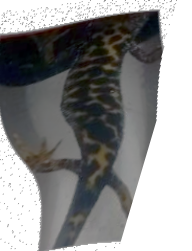

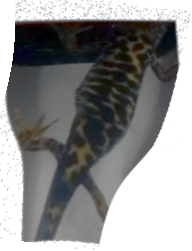

In [58]:
# image shearing using sklearn.transform.AffineTransform
# try out with differnt values of shear 
tf = AffineTransform(shear=-0.3)
sheared = transform.warp(img, tf, order=1, preserve_range=True,mode='constant', cval=255)
#sheared_fig = plot_side_by_side(img, sheared, 'Original', 'Sheared')
#plt.title('shear')
#plt.imshow(sheared)
cv2_imshow(sheared)

swirled = swirl(sheared, rotation=0, strength=-1, radius=500,mode='constant', cval=255)
#plt.imshow(swirled)
cv2_imshow(swirled)

(251, 192, 3)


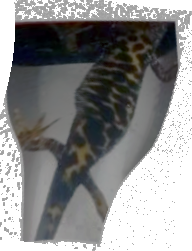

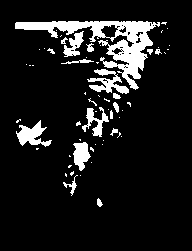

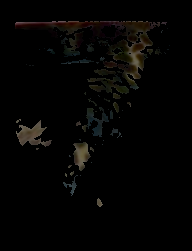

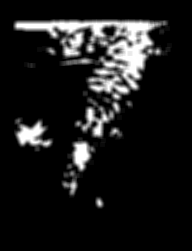

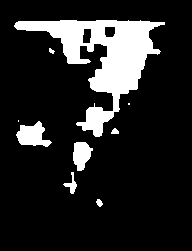

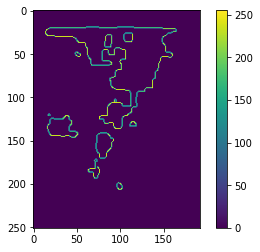

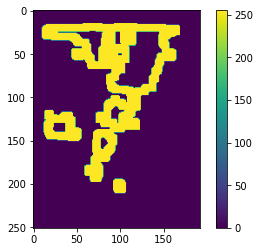

shape of cnt: (208, 1, 2)


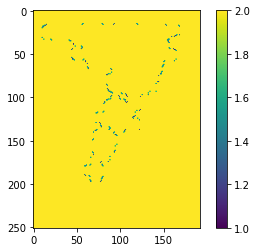

10916.5
rect: ((89.0, 106.0), (158.0, 182.0), -0.0)


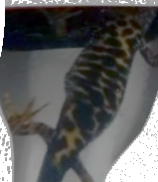

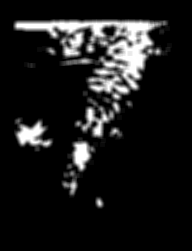

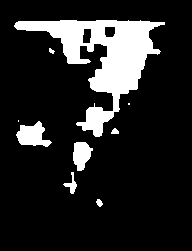

In [60]:
mask_blur = cv2.GaussianBlur(mask,(5,5),cv2.BORDER_DEFAULT)

threshMap = cv2.threshold(mask_blur.astype("uint8"), 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

kernel = np.ones((7,7),np.uint8)
threshMap = cv2.dilate(threshMap, kernel)
threshMap = cv2.erode(threshMap, kernel)


cv2_imshow(mask_blur)
cv2_imshow(threshMap)

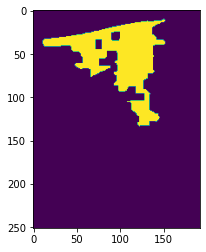

In [53]:
import skimage
from skimage import measure

# Extract the greatest region 

labels_mask = measure.label(threshMap)                       
regions = measure.regionprops(labels_mask)
regions.sort(key=lambda x: x.area, reverse=True)
if len(regions) > 1:
    for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
labels_mask[labels_mask!=0] = 1
mask = labels_mask
plt.imshow(mask)

In [0]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

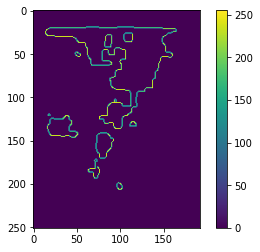

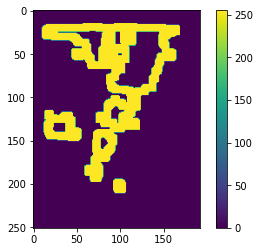

shape of cnt: (208, 1, 2)


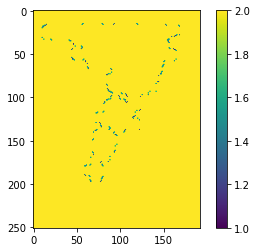

10916.5


In [61]:
canny_output = auto_canny(threshMap, sigma = 0.3)
#canny_output = cv2.convertScaleAbs(canny_output)
kernel = np.ones((9,9),np.uint8)
threshed = cv2.dilate(canny_output,kernel)


#print(canny_output[1])
plt.imshow(canny_output)
plt.colorbar()
plt.show()


## findContours(查找轮廓)
cnts = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]

#print(cnts[0])
plt.imshow(threshed)
plt.colorbar()
plt.show()
#print(cnts.shape)

#new,contours, hierarchy = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#contours= sorted(contours, key = cv2.contourArea, reverse = True)[:4]
#c=contours[0]
#print(cv2.contourArea(c))
#final = cv2.drawContours(img, [c], -1, (255,0, 0), 3)


#cnts = canny_output
#cnts = sorted(canny_output, key=cv2.contourArea)
## sorted by area(按照面积排序)
cnts = sorted(cnts, key=cv2.contourArea)

## get the maximum's boundinRect(获取最大边缘的外接矩形)
cnt = cnts[-1]

## create mask(创建掩模)
mask = np.ones_like(threshMap, np.uint8)*cv2.GC_PR_BGD
cv2.drawContours(mask, cnt, -1, cv2.GC_FGD, -1)

print("shape of cnt: {}".format(cnt.shape))

plt.imshow(mask)
plt.colorbar()
plt.show()

#new_image = cv2.bitwise_and(img,img,mask=mask)
#print(mask)
new_image = threshMap.copy()
new_image[mask == 2] = 0  # Set values not masked to be 0

#plt.imshow(new_image)
#plt.colorbar()
#plt.show()

retval = cv2.contourArea(cnt)
print(retval)


rect: ((89.0, 106.0), (158.0, 182.0), -0.0)


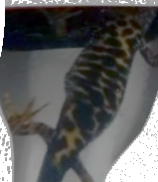

In [62]:

rect = cv2.minAreaRect(cnt)
print("rect: {}".format(rect))

box = cv2.boxPoints(rect)
box = np.int0(box)

width = int(rect[1][0])
height = int(rect[1][1])

src_pts = box.astype("float32")
dst_pts = np.array([[0, height-1],
                    [0, 0],
                    [width-1, 0],
                    [width-1, height-1]], dtype="float32")
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped = cv2.warpPerspective(img, M, (width, height))

cv2_imshow(warped)

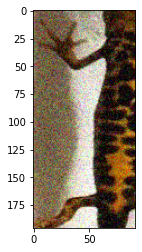

In [0]:
# Apply Random Noise to image using skimage.utils.random_noise
noised = random_noise(img, var=0.1**2)
plt.imshow(noised)


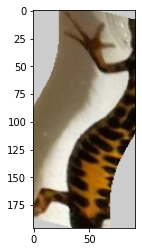

In [0]:
swirled = swirl(img, rotation=0, strength=-1, radius=500,mode='constant', cval=0.80,)
plt.imshow(swirled)

In [0]:
#data = pd.read_csv('/content/training.csv',)
def augmentationImage(img_path,img_aug_path):

  input_shape = (100,75,3)
  
  !rm -rf /content/databaseAug
  data = pd.read_csv('/content/training.csv',)
  #data = data.to_numpy()
  labels = data.iloc[:,4]
  #print(labels.head())
  names = data.iloc[:,0]
  #print(names.head())
  #abels.head()
  labels_uniques, counts = np.unique(labels, return_counts=True)
  
  #print(labels_uniques)
  for label in labels_uniques:
    os.makedirs(img_aug_path+'/train/'+label)
    os.makedirs(img_aug_path+'/test/'+label)


  print("Création de la base de données augmentées en cours...")
  # List all files in a directory using scandir()
  basepath = '/content/database'
  with os.scandir(img_path) as images:
    for im in images:
      #print(im.name)
      if(im.name in names.values):
        
        id = names[names == im.name].index[0]
        #id = names.loc[im.name]
        #print(id)
        label = labels.iloc[id]
        #print('label : '+label)
        id_label = np.where(labels_uniques == label)
        #print(id_label)
        imagePath = basepath + '/' + im.name
        #print(imagePath)
        
        count = counts[id_label]
        #print(count)
        #img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1024_20190605213228.jpg'
        img = prepare_img(input_shape,imagePath)
        #image = cv2_imread(path + '/' + im.name)
        
        
        k = 0
        while (k < int(500/count)):  ######### DIVISER PAR COUNT QUAND BASE DE DONNEE COMPLETE
          image = tf.image.random_brightness(img, max_delta=0.15) # Random brightness
          image = tf.image.random_flip_left_right(image)
          image = tf.image.random_flip_up_down(image)
          image = tf.image.random_contrast(image,0.5,3)
          image = tf.image.random_saturation(image,0.5,3)
          
         
          augPath = img_aug_path+'/train/'+label+'/' + im.name[:-4] + str(k) + '.jpg'
          #augPath = img_aug_path+'/test/'+label+'/' + im.name + str(k)
          save_img(augPath, image)

          k += 1

img_path = '/content/database'
img_aug_path = '/content/databaseAug'
augmentationImage(img_path,img_aug_path)

Création de la base de données augmentées en cours...


Séparation en train et test set

In [0]:

train_path = '/content/databaseAug/train'
test_path = '/content/databaseAug/test'
dest1 =  pathlib.Path(test_path)
source1 = pathlib.Path(train_path)

for label in os.listdir(train_path):
  if len(os.listdir(train_path + '/' + label)) == 0: # Check if empty..
    shutil.rmtree(train_path + '/' + label) # Delete..

import fnmatch



for class_name in os.listdir(train_path):
      

      class_path = os.path.join(source1, class_name)
      class_path_test = os.path.join(dest1, class_name)
      #os.mkdir(class_path_test)
      #label_map_dict[class_name]=count_label
      imgs = fnmatch.filter(os.listdir(class_path), '*.jpg')
      nbr_img = len(imgs)

      idx = np.arange(nbr_img)
      idx_test = np.random.choice(idx, size=10, replace=False)
      print(len(os.listdir(class_path)))

      #Copie de certains éléments dans le test set
      for i in range (len(os.listdir(class_path))):
        if i in idx_test:
          print(str(class_path) + '/'+ str(os.listdir(class_path)[i]))
          shutil.copy(str(class_path) + '/'+ str(os.listdir(class_path)[i]), str(class_path_test) + '/'+ str(os.listdir(class_path)[i]))
      #Suppression des éléments copiés dans le train set
      files = os.listdir(class_path)
      for i in range (len(files)):
        if i in idx_test:
          print(str(class_path) + '/'+ str(files[i]))
          file_path = pathlib.Path(str(class_path) + '/'+ str(files[i]))
          os.remove(file_path)
          #print("removed")


for label in os.listdir(test_path):
  if len(os.listdir(test_path + '/' + label)) == 0: # Check if empty..
    shutil.rmtree(test_path + '/' + label) # Delete..

Streaming output truncated to the last 5000 lines.
/content/databaseAug/train/KM00477/Bascha_P01_T03_K11_M_Adult_218_20190517030718482.jpg
500
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_2019043022463395.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_20190430224633258.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_201904302246335.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_20190430224633431.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_20190430224633211.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_20190430224633394.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_20190430224633158.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_20190430224633181.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adult_4813_20190430224633236.jpg
/content/databaseAug/train/KM00730/Bascha_P01_T04_K05_M_Adu

In [0]:


def get_label(file_path):
  # convert the path to a list of path components
  #parts = str(file_path).split("/")
  parts = tf.strings.split(file_path, os.path.sep)
  #print(type(parts[-1]))
  #print(parts[-1].numpy().decode("utf-8"))
  #test = str(parts)
  
  #for part in parts:
   # print(part)
  #lab = parts[-2].numpy().decode("utf-8")  + '/'+ parts[-1].numpy().decode("utf-8")
  #lab = parts[-1]
  #print(lab)
  #print(parts.  )

  #for l in np.range(lab):
    #print(l)

  i = 0
  while (parts[-1].numpy().decode("utf-8")[i] != "_"):
    i += 1
  
  #id = patterns[patterns == lab]
  #if (id.empty):
  #print(lab)

  
  # The second to last is the class-directory
  #print( tf.convert_to_tensor(lab[:i]))
  #print(CLASS_NAMES)
  #print(type(tf.convert_to_tensor(parts[-1].numpy().decode("utf-8")[:i])))
  #print(CLASS_NAMES[0])
  #print(type(CLASS_NAMES[0]))
  return tf.convert_to_tensor(parts[-1].numpy().decode("utf-8")[:i]) == CLASS_NAMES
  #assert not id.empty 
  #print(id.index)

 # id = ids.iloc[id.index]
  #print(id)
  # The second to last is the class-directory
  #print(type(tf.convert_to_tensor(id)))
  #return tf.convert_to_tensor(id)[0]
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [width, height])

def process_path(file_path):
  #print(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  #print(img)
  try:
    img = decode_img(img)
    #print("decoded")
    counter +=1
  except:
   # print("erreur décodage")
    pass

  return img, label

In [0]:
length = len(os.listdir('/content/databaseAug/train/KM00666'))
print(length)


179


500


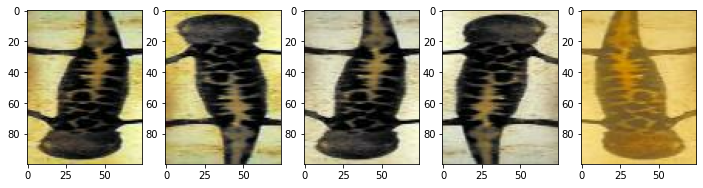

In [0]:
def visualize(label_path):
  fig = plt.figure()
  images = os.listdir(label_path)
  for i in range(1,6):
    plt.subplot(1,5,i)
    #plt.title('Original image')
    img_path = label_path + '/' + images[i-1]
    img = tf.io.read_file(img_path)
    img = decode_img(img)
    plt.imshow(img)

visualize('/content/databaseAug/train/KM00083')

In [0]:

!rm -rf /content/databaseAug
data = pd.read_csv('/content/training.csv')
labels = data.iloc[1:,4]
labels.head()
labels = np.unique(labels)
for label in labels:
  os.makedirs('databaseAug/train/'+label)
  os.makedirs('databaseAug/test/'+label)



In [0]:



ds_path = "/content/content/Stage/database/dataset_regroupe"
ds_path = pathlib.Path(ds_path)

ds_dir = os.listdir(ds_path)

CLASS_NAMES = []

for pattern in ds_dir:
  i = 0
  while (pattern[i] != "_"):
    i += 1
  CLASS_NAMES.append(pattern[:i])
  #print(pattern[:i])

CLASS_NAMES = np.array(CLASS_NAMES)
CLASS_NAMES = np.unique(CLASS_NAMES)

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

def augment(image,label):
  #image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.image.flip_left_right(image)

  return image,label

FileNotFoundError: ignored